In [1]:
import numpy as np
from datetime import datetime
from datetime import timedelta
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

# Valuación de derivados

Utilizando los valores

* $S_0=100$
* $K=110$
* $T = 2021/12/28$ (año/mes/día)
* $r = 0.01$
* $\sigma = 0.2$
* $t = 2020/06/10$ (año/mes/día)

Calcule el valor de una opción call europea utilizando simulación (con el esquema de Euler y el método de Monte Carlo) y compare sus resultados con la fórmula analítica de Black-Scholes.

Utilice un tamaño de paso $N =365$ y simule $5,000$ trayectorias. Considere que el año tiene 360 días.

**Sugerencias**

```python
from scipy.stats import norm

#Para simular una variable aleatoria
#con distribución normal estándar (media = 0, desviación = 1)
z = norm.rvs()

#Para calcular la función de distribución
#de una variable aleatoria normal
norm.cdf(x)

help(np.max) #Recuerde que numpy vectoriza operaciones
help(np.sqrt)
help(np.exp) #Función exponencial
```

https://docs.scipy.org/doc/scipy/reference/stats.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm

In [2]:
#GLOBAL días en el año
D_YEAR = 360

In [3]:
def payoff_call_europeo(trayectoria, strike):
    '''
    Calcual el payoff de un call europeo
    
    ENTRADA
    trayectoria: numpy array con la trayectoria simulada del subyacente
    
    strike: Float que representa el precio strike
    
    SALIDA
    float que representa el payoff
    '''
    
    #Sólo se necesita el último precio
    return np.max([trayectoria[-1] - strike, 0])

def simula_trayectoria_bs(s0, strike, r, sigma, T, t, n_pasos = 365):
    '''
    Función para simular la trayectoria del subyacente de acuerdo al modelo de Black-Scholes
    
    ENTRADA
    s0: Precio inicial (float)
    
    strike: Precio strike (float)
    
    r: tasa libre de riesgo en decimales (float)
    
    sigma: Volatilidad en decimales (float)
    
    T: Fecha de vencimiento, objeto datetime.datetime
    
    t: Fecha de valuación objeto datetime.datetime
    
    n_pasos: Entero que representa la cantidad de precios simulados para llegar a S_T
    
    SALIDA
    numpy array que contiene la trayectoria del subyacente
    '''
    
    #Delta y su raíz
    dias = (T-t).days
    delta =  ( dias / D_YEAR ) / n_pasos
    sqrt_de = np.sqrt(delta)
    
    #Aquí almaceno la trayectoria
    trayectoria = []
    
    #Primer precio es el mismo para todas las trayectorias
    trayectoria.append(s0)
    
    #Aplica esquema de Euler
    for i in range(1, n_pasos):
        
        nuevo_precio = trayectoria[i - 1] * ( 1 + r * delta + sigma * sqrt_de * norm.rvs() )
        trayectoria.append(nuevo_precio)
    
    #convierte a numpy array
    trayectoria = np.array(trayectoria)
    
    return trayectoria


def aproxima_precio(fun_payoff, s0, strike, r, sigma, T, t, n_pasos = 365, n_sim = 1000):
    '''
    Función para aproximar el precio de un derivado para un payoff en particular
    
    ENTRADA
    fun_payoff: Función para calcular el payoff
    
    s0: Precio inicial (float)
    
    strike: Precio strike (float)
    
    r: tasa libre de riesgo en decimales (float)
    
    sigma: Volatilidad en decimales (float)
    
    T: Fecha de vencimiento objeto datetime.datetime
    
    t: Fecha de valuación objeto datetime.datetime
    
    n_pasos: Entero que representa la cantidad de precios simulados para llegar a S_T
    
    n_sim: Entero que representa el número de trayectorias para calcular el precio (aproximar la esperanza)
    
    SALIDA
    float
    '''
    
    #Aquí almaceno el payoff de cada trayectoria
    payoffs = []
    
    for i in range(n_sim):
        
        #Simula una trayectoria
        trayectoria = simula_trayectoria_bs(s0, strike, r, sigma, T, t, n_pasos)
        
        #Calcula el payoff de la trayectoria
        payoffs.append(fun_payoff(trayectoria, strike))
    
    #Promedia los payofss y trae a valor presente (aproxima el precio)
    dias = (T - t).days
    tau = dias / D_YEAR
    precio = np.exp(-r * (tau)) * np.mean(payoffs)
    
    return precio

def Call_Black_Scholes(S, K, T, t, r, sigma):
    '''
    Calcula el precio de una opción call europea
    utilizando la fórmula de Black Scholes
    '''
    dias = (T-t).days
    tau = dias / D_YEAR
    
    d1 = ( np.log(S / K) + (r + 0.5 * sigma**2) * tau ) / ( sigma * np.sqrt(tau) )
    d2 = ( np.log(S / K) + (r - 0.5 * sigma**2) * tau ) / ( sigma * np.sqrt(tau) )
    
    precio = S * norm.cdf(d1) - np.exp(-r * (tau)) * K * norm.cdf(d2)
    
    return precio

In [4]:
#Fecha de valuación
t = datetime.strptime("2020/06/10", "%Y/%m/%d")

#Fecha de vencimiento
T = datetime.strptime("2021/12/28", "%Y/%m/%d")

strike = 110

s0 = 100

r = 0.01

sigma = 0.2

n_pasos = 365

n_sim = 5000

precio_simulado = aproxima_precio(payoff_call_europeo, s0 = s0, strike = strike, r = r, sigma = sigma,\
                                  T = T, t = t, n_pasos = n_pasos, n_sim = n_sim)
precio_bs = Call_Black_Scholes(S = s0, K = strike, T = T, t = t, r = r, sigma = sigma)

In [5]:
print('Precio con simulación', np.round(precio_simulado, 4))
print('Precio con fórmula analítica', np.round(precio_bs, 4))

Precio con simulación 6.6121
Precio con fórmula analítica 6.7656


# Volatilidad implícita

Utilizando los valores

* $S_0=100$
* $K=110$
* $T = 2021/12/28$ (año/mes/día)
* $r = 0.01$
* $t = 2020/06/10$ (año/mes/día)

y el precio de la opción call observado en el mercado $P_{mercado} = 10$, calcule la volatilidad implícita resolviendo el siguiente problema de optimización

$$
VolImp = argmin_{\sigma > 0} \left( P_{mercado} - P_{BS} \right)^2
$$

en donde $P_{BS}$ es el precio de la opción call utilizando la fórmula analítica de Black-Scholes.

Como solución inicial $\sigma_0 = 0.05$

**Sugerencias**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.Bounds.html#scipy.optimize.Bounds

Para minimizar utilice el método `L-BFGS-B`.

In [6]:
def Call_Black_Scholes(S, K, T, t, r, sigma):
    '''
    Calcula el precio de una opción call europea utilizando la fórmula de Black Scholes
    '''
    #Calcula el plazo para el vencimiento
    #en años
    dias = (T - t).days
    tau = dias / D_YEAR
    
    d1 = ( np.log(S / K) + (r + 0.5 * sigma**2)* tau ) / ( sigma * np.sqrt(tau) )
    d2 = ( np.log(S / K) + (r - 0.5 * sigma**2)* tau ) / ( sigma * np.sqrt(tau) )
    
    precio = S*norm.cdf(d1) - np.exp(-r*(tau))*K*norm.cdf(d2)
    
    return precio


def fun_obj(sigma, *args):
    '''
    Calcula la función objetivo (P_mercado - P_BS)^2
    
    ENTRADA
    sigma: numpy array que contiene el valor de la volatilidad
    
    *args: tupla que contiene un diccionario (args[0]), el cual contiene los parámetros para determinar
    el precio utilizando la fórmula de Black-Scholes
    
    SALIDA
    float que representa el valor de la función objetivo para el valor de sigma
    '''
    
    #Extrae parámetros del diccionario
    dicc_args = args[0]
    S = dicc_args['S']
    K = dicc_args['K']
    T = dicc_args['T']
    r = dicc_args['r']
    precio_mercado = dicc_args['mercado'] #Precio del call en el mercado
    
    #Calcula el precio con la fórmula de Black-Scholes
    precio_bs = Call_Black_Scholes(S, K, T, t, r, sigma[0])
    
    return (precio_mercado - precio_bs)**2
    

In [7]:
#define parámetros
S = 100
K = 110
t = datetime.strptime("2020/06/10", "%Y/%m/%d")
T = datetime.strptime("2021/12/28", "%Y/%m/%d")
r = 0.01
precio_mercado = 10

#junta los parámetros en un diccionario
dicc_args  = {}
dicc_args['S'] = S
dicc_args['K'] = K
dicc_args['T'] = T
dicc_args['t'] = t
dicc_args['r'] = r
dicc_args['mercado'] = precio_mercado

#Define la cota para sigma
cota = Bounds(lb =[0], ub = [np.inf])

#solución inicial
sig_0 = np.array([0.05])

#Encuentra la solución
solucion = minimize(fun_obj, x0 = sig_0, args = (dicc_args), method = 'L-BFGS-B', bounds = cota)
print('La volatilidad implícita es', np.round(solucion.x[0], 4))

#Se valida calculando el precio con el modelo de Black-Scholes y la volatilidad implícita
precio_bs_vol_im = Call_Black_Scholes(S, K, T, t, r, solucion.x[0])

print('El precio con el modelo de Black-Scholes utilizando la volatilidad implícita es', np.round(precio_bs_vol_im, 4))

La volatilidad implícita es 0.2652
El precio con el modelo de Black-Scholes utilizando la volatilidad implícita es 10.0


# Gráfica de trayectorias

Utilizando los datos el primer ejercicio, grafique 50 trayectorias.

**Sugerencias**

* No es necesario que el eje x tengas las fechas

```python
import matplotlib.pyplot as plt

help(plt.grid)
help(plt.ylabel)
help(plt.title)
```

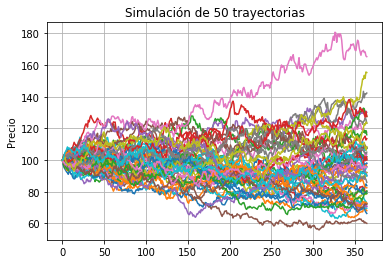

In [8]:
#Fecha de valuación
t = datetime.strptime("2020/06/10", "%Y/%m/%d")

#Fecha de vencimiento
T = datetime.strptime("2021/12/28", "%Y/%m/%d")

strike = 100

s0 = 100

r = 0.01

sigma = 0.2

n_pasos = 365

#número de trayectorias
n_tray = 50

for i in range(n_tray):
    #Obtiene trayectoria
    trayectoria = simula_trayectoria_bs(s0, strike, r, sigma, T, t, n_pasos)
    
    #Grafica
    plt.plot(trayectoria, '-')

plt.grid()
plt.ylabel('Precio')
plt.title(f'Simulación de {n_tray} trayectorias')
plt.show()    
    